# Email spam Detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dataset/spam.csv',encoding='latin-1')
df.head(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 1 - Data Cleaning

**Dropping Unncessary Columns**

In [3]:
df = df.drop(columns = ['Unnamed: 2' , 'Unnamed: 3' , 'Unnamed: 4'])
df.head(5)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Renaming the Columns**

In [4]:
df.rename(columns = {'v1' : 'Label' , 'v2' : 'text'},inplace=True)
df.head(5)

,Label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

In [6]:
df['Label'].value_counts()

Label
ham     4825
spam     747
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
df.isnull().sum()

Label    0
text     0
dtype: int64

**Encoding**

where:
- 0 : Ham
- 1 : Spam

In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Label'])
df.head(5)

,Label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Checking the Duplicate Values**

In [10]:
df.duplicated().sum()

403

In [11]:
df = df.drop_duplicates(keep = 'first')
df.head(5)

,Label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.duplicated().sum()

0

In [13]:
df.shape

(5169, 2)

## 2 - Preprocessing

In [14]:
df['Label'].value_counts().reset_index()

,Label,count
0,0,4516
1,1,653


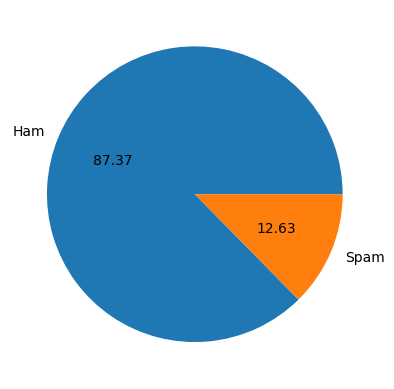

In [15]:
plt.pie(df['Label'].value_counts() , labels = ['Ham' , 'Spam'] , autopct = '%0.2f')
plt.show()

Here we can see that Our Data is **Imbalanced**

In [17]:
from sklearn.model_selection import train_test_split 
x = df["text"]  
y = df["Label"]

# Split FIRST to isolate test set
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

We used stratify to ensure the class proportions are equal in both sets

In [72]:
y_test.value_counts()

Label
0    903
1    131
Name: count, dtype: int64

In [71]:
y_train.value_counts()

Label
0    3613
1     522
Name: count, dtype: int64

- To handel the problem of imbalanced data we will use smote after tfidf to be the data numeric
- we use tfidf just for train set to be the idf correct and related to train set only

In [78]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Preprocessing function (lowercase + remove punctuation)
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Preprocess ONLY training data
X_train_processed = X_train_raw.apply(preprocess)

# TF-IDF on training data
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_vec = tfidf.fit_transform(X_train_processed)  # Fit on train only

# SMOTE on training data
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_vec, y_train)

In [79]:
# Preprocess test data (same function as train)
X_test_processed = X_test_raw.apply(preprocess)

# Vectorize test data using the SAME tfidf object (no refitting!)
X_test_vec = tfidf.transform(X_test_processed)

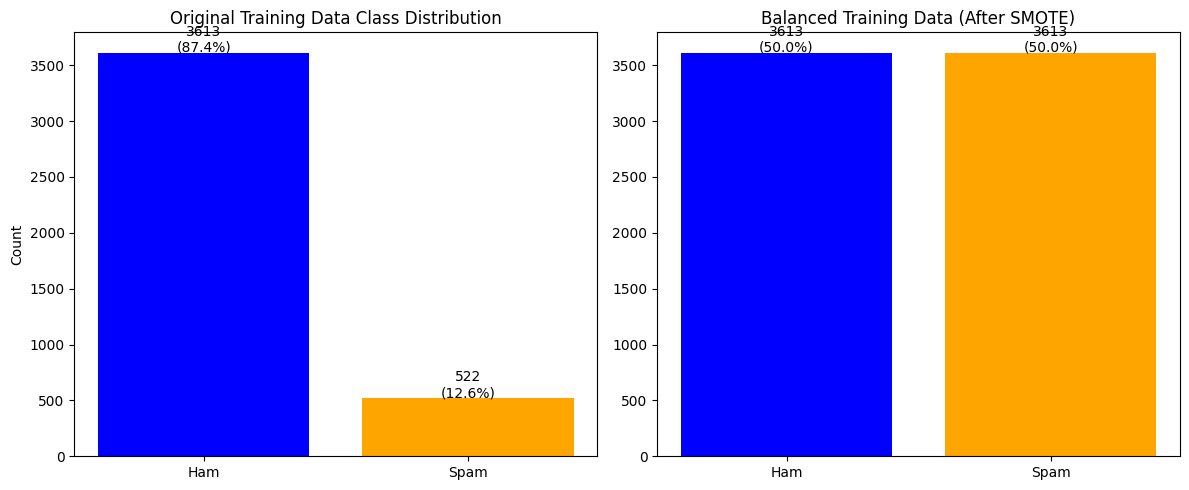

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Get class counts
original_train_counts = y_train.value_counts()
balanced_train_counts = y_train_bal.value_counts()

# Create plot with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE (Training Data)
ax[0].bar(['Ham', 'Spam'], original_train_counts, color=['blue', 'orange'])
ax[0].set_title('Original Training Data Class Distribution')
ax[0].set_ylabel('Count')
for i, count in enumerate(original_train_counts):
    ax[0].text(i, count + 5, f"{count}\n({count/len(y_train):.1%})", ha='center')

# After SMOTE (Balanced Training Data)
ax[1].bar(['Ham', 'Spam'], balanced_train_counts, color=['blue', 'orange'])
ax[1].set_title('Balanced Training Data (After SMOTE)')
for i, count in enumerate(balanced_train_counts):
    ax[1].text(i, count + 5, f"{count}\n({count/len(y_train_bal):.1%})", ha='center')

plt.tight_layout()
plt.show()

## 3- Training

Classification Report:
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.99       903
        Spam       0.93      0.89      0.91       131

    accuracy                           0.98      1034
   macro avg       0.96      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034

ROC Curve:


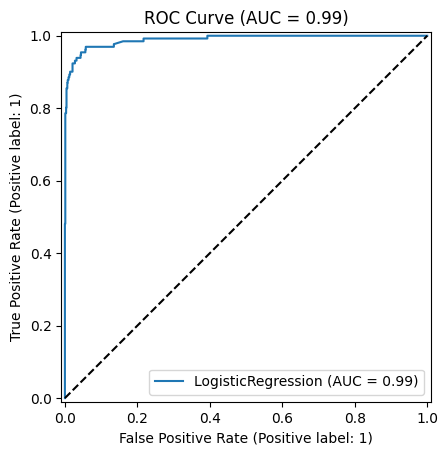


Confusion Matrix:


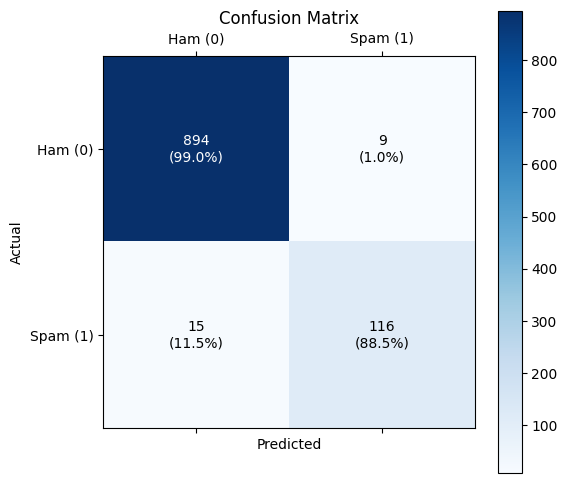

In [90]:
# Logistic regression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

# Train model
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_bal, y_train_bal)

# Predictions
y_pred = lr.predict(X_test_vec)
y_proba = lr.predict_proba(X_test_vec)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# ROC Curve
print("ROC Curve:")
RocCurveDisplay.from_estimator(lr, X_test_vec, y_test)
plt.title(f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f"{val}\n({val/cm.sum(axis=1)[i]:.1%})", 
            ha='center', va='center', 
            color='white' if val > cm.max()/2 else 'black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Ham (0)', 'Spam (1)'])
ax.set_yticklabels(['Ham (0)', 'Spam (1)'])
plt.title('Confusion Matrix')
plt.show()


Gaussian Naive Bayes Results:
              precision    recall  f1-score   support

         Ham       0.98      0.88      0.93       903
        Spam       0.51      0.87      0.64       131

    accuracy                           0.88      1034
   macro avg       0.74      0.87      0.78      1034
weighted avg       0.92      0.88      0.89      1034

ROC-AUC: 0.8737


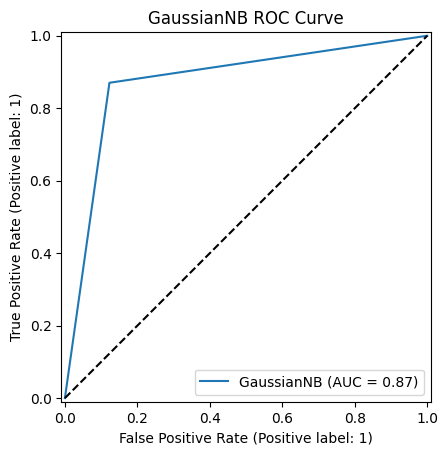


Confusion Matrix:


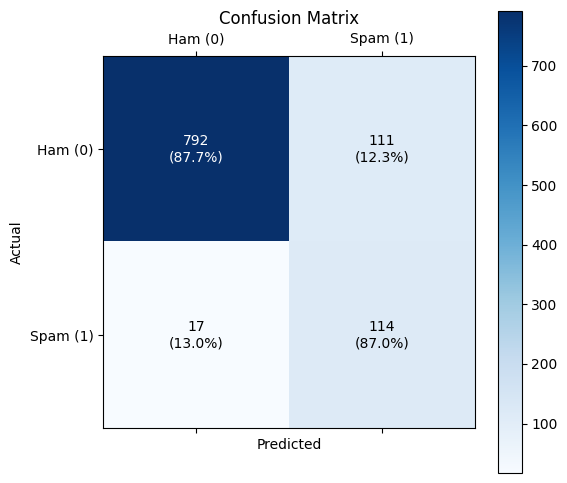

In [84]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Convert sparse matrices to dense (required by GaussianNB)
X_train_dense = X_train_bal.toarray()  # After SMOTE
X_test_dense = X_test_vec.toarray()     # Test data

# Train GaussianNB
nb = GaussianNB()
nb.fit(X_train_dense, y_train_bal)

# Predictions
y_pred = nb.predict(X_test_dense)
y_proba = nb.predict_proba(X_test_dense)[:, 1]

# Evaluation
print("\nGaussian Naive Bayes Results:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(nb, X_test_dense, y_test)
plt.title('GaussianNB ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f"{val}\n({val/cm.sum(axis=1)[i]:.1%})", 
            ha='center', va='center', 
            color='white' if val > cm.max()/2 else 'black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Ham (0)', 'Spam (1)'])
ax.set_yticklabels(['Ham (0)', 'Spam (1)'])
plt.title('Confusion Matrix')
plt.show()


Random Forest Results:
              precision    recall  f1-score   support

         Ham       0.95      1.00      0.97       903
        Spam       0.97      0.66      0.78       131

    accuracy                           0.95      1034
   macro avg       0.96      0.83      0.88      1034
weighted avg       0.95      0.95      0.95      1034

ROC-AUC: 0.9747


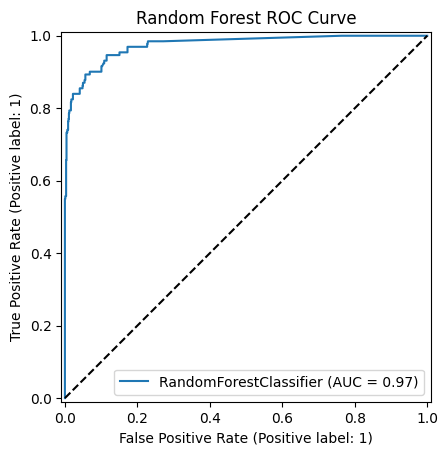


Confusion Matrix:


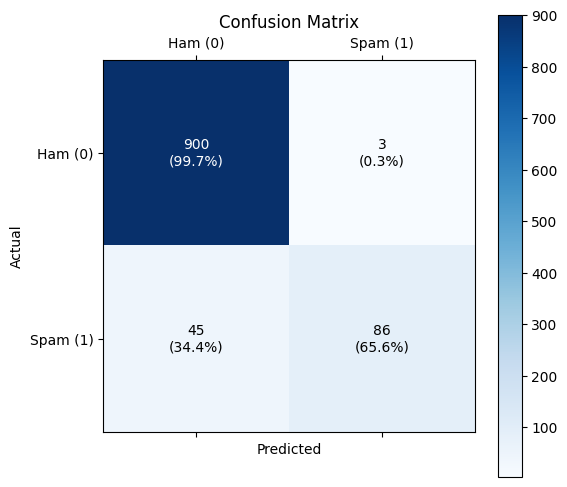

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, RocCurveDisplay, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest on BALANCED training data
rf = RandomForestClassifier(
    class_weight='balanced_subsample',  # Handles residual imbalance
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf.fit(X_train_bal, y_train_bal)  # X_train_bal is TF-IDF + SMOTE output

# Predictions
y_pred = rf.predict(X_test_vec)  # X_test_vec: preprocessed + vectorized test data
y_proba = rf.predict_proba(X_test_vec)[:, 1]

# Evaluation
print("\nRandom Forest Results:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")

# ROC Curve (use vectorized test data)
RocCurveDisplay.from_estimator(rf, X_test_vec, y_test)
plt.title('Random Forest ROC Curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar(cax)
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f"{val}\n({val/cm.sum(axis=1)[i]:.1%})", 
            ha='center', va='center', 
            color='white' if val > cm.max()/2 else 'black')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Ham (0)', 'Spam (1)'])
ax.set_yticklabels(['Ham (0)', 'Spam (1)'])
plt.title('Confusion Matrix')
plt.show()